In [1]:
import numpy as np
from numpy.random import default_rng
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform, OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
from numpyro.diagnostics import effective_sample_size, print_summary
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
from jax.tree_util import tree_flatten, tree_map
from jax.scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import ete3


/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
d = pd.read_csv('data/WaffleDivorce.csv', sep=';')

In [6]:
d.sample(5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
12,Idaho,ID,1.57,23.2,25.8,1.84,7.7,1.05,0,0,0,0,0.0
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.0
15,Iowa,IA,3.05,25.4,21.5,1.46,10.2,0.91,0,0,0,674913,0.0
45,Virginia,VA,8.00,26.4,20.5,0.83,8.9,0.52,40,1,490865,1219630,0.4
44,Vermont,VT,0.63,26.9,16.4,2.40,9.6,1.87,0,0,0,315098,0.0


<AxesSubplot:xlabel='MedianAgeMarriage', ylabel='Divorce'>

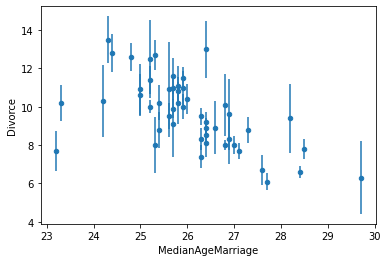

In [9]:
d.plot.scatter('MedianAgeMarriage', 'Divorce', yerr='Divorce SE')

In [19]:
scaler = StandardScaler()
AMD = scaler.fit_transform(d[['MedianAgeMarriage', 'Marriage', 'Divorce']])
D_se = d['Divorce SE']/np.std(d['Divorce'])

In [20]:
def model(A, M, D_obs, D_se):

    a = numpyro.sample('a', dist.Normal(0,0.2))
    b_A = numpyro.sample('b_A', dist.Normal(0,0.5))
    b_M = numpyro.sample('b_M', dist.Normal(0,0.5))
    s = numpyro.sample('s', dist.Exponential(1))
    mu = a + b_A * A + b_M * M
    d = numpyro.sample('d', dist.Normal(mu, s))
    result = numpyro.sample('result', dist.Normal(d, D_se), obs=D_obs)


m15_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_1.run(random.PRNGKey(0), A=AMD[:,0], M=AMD[:,1], D_obs=AMD[:,2], D_se=D_se.values)
m15_1.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 3525.73it/s, 15 steps of size 3.11e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.05      0.10     -0.05     -0.21      0.11   3200.35      1.00
       b_A     -0.62      0.16     -0.62     -0.87     -0.35   2066.92      1.00
       b_M      0.04      0.17      0.05     -0.23      0.33   1892.28      1.00
      d[0]      1.19      0.37      1.18      0.56      1.75   3186.88      1.00
      d[1]      0.68      0.55      0.68     -0.22      1.55   4619.65      1.00
      d[2]      0.43      0.34      0.43     -0.13      0.99   6085.98      1.00
      d[3]      1.42      0.46      1.40      0.68      2.24   4529.18      1.00
      d[4]     -0.91      0.13     -0.91     -1.11     -0.69   6256.72      1.00
      d[5]      0.66      0.41      0.66      0.04      1.36   4711.55      1.00
      d[6]     -1.38      0.34     -1.37     -1.98     -0.87   4416.26      1.00
      d[7]     -0.36      0.50     -0.35     -1.18      0.45   4154.58      1.00
      d[8]     -1.90      0

### Missing Data

In [3]:
rng = default_rng(42)
N = 100
S = rng.normal(size=N)
H = rng.binomial(10, expit(S), N)

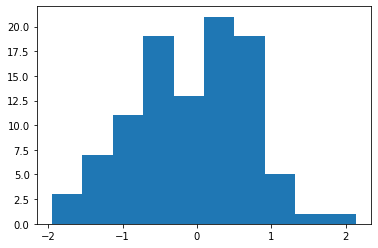

In [4]:
_ = plt.hist(S)

In [47]:
# Missing at random
D = rng.binomial(1,0.5,N)
Hm = np.where(D==1,np.nan, H)

In [7]:
def model(s, h):
    
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))
    logit = a + b*s 
    obs = numpyro.sample('obs_homework', dist.BinomialLogits(logit, 10), obs=h)

m15_2 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_2.run(random.PRNGKey(0), s=S, h=H)
m15_2.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 6459.97it/s, 3 steps of size 9.82e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.05      0.07     -0.05     -0.16      0.06   2068.01      1.00
         b      0.97      0.09      0.97      0.81      1.12   1888.67      1.00

Number of divergences: 0


In [49]:
m15_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_3.run(random.PRNGKey(0), s=S[D==0], h=H[D==0])
m15_3.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 4153.03it/s, 3 steps of size 9.21e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.10     -0.12     -0.29      0.03   1418.49      1.00
         b      0.94      0.14      0.94      0.70      1.18   1740.41      1.00

Number of divergences: 0


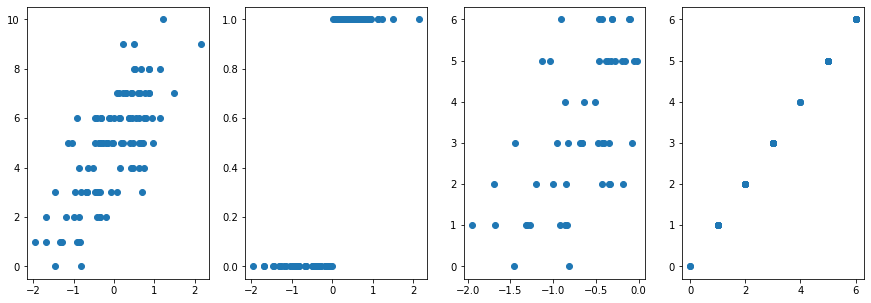

In [5]:
# Studying influences liklihood of dog eating homwwork
D = np.where(S>0,1,0)
Hm = np.where(D==1,np.nan, H)

fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].scatter(S, H)
ax[1].scatter(S, D)
ax[2].scatter(S, Hm)
ax[3].scatter(H, Hm)

In [8]:
m15_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_4.run(random.PRNGKey(0), s=S, h=H)
m15_4.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 5759.36it/s, 3 steps of size 9.82e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.05      0.07     -0.05     -0.16      0.06   2068.01      1.00
         b      0.97      0.09      0.97      0.81      1.12   1888.67      1.00

Number of divergences: 0


In [9]:
m15_5 = MCMC(NUTS(model), num_warmup=500, num_samples=5000, num_chains=1)
m15_5.run(random.PRNGKey(0), s=S[D==0], h=H[D==0])
m15_5.print_summary()

sample: 100%|██████████| 5500/5500 [00:03<00:00, 1441.59it/s, 3 steps of size 4.90e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.16      0.02     -0.26      0.27   1695.83      1.00
         b      1.11      0.21      1.11      0.74      1.46   1781.58      1.00

Number of divergences: 0


sample: 100%|██████████| 5500/5500 [00:03<00:00, 1620.11it/s, 3 steps of size 4.35e-01. acc. prob=0.93]


Mean a:  -0.027219355723354967
Mean b:  0.9762196385860443


array([[1.        , 0.69970488],
       [0.69970488, 1.        ]])

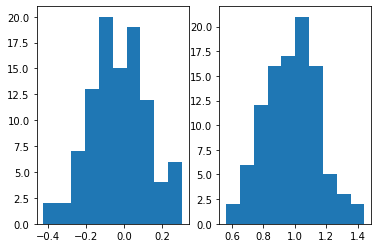

In [10]:
rng = default_rng(42)

def mk_data(rng, N=100):

    S = rng.normal(size=N)
    H = rng.binomial(10, expit(S), N)
    D = np.where(S>0,1,0)

    return S[D==0], H[D==0]

a_list = []
b_list = []

for i in range(100):

    # Generate data
    s, h = mk_data(rng)

    # Estimate model
    m15_5.run(random.PRNGKey(0), s, h)

    # Get mean a, b
    post = m15_5.get_samples()
    a, b = post['a'].mean().item(), post['b'].mean().item()

    # Store a, b
    a_list.append(a)
    b_list.append(b)


# Summarise a, b
fig, ax = plt.subplots(1, 2)
_ = ax[0].hist(a_list)
_ = ax[1].hist(b_list)

print('Mean a: ', np.mean(a_list))
print('Mean b: ', np.mean(b_list))
np.corrcoef(np.array([a_list,b_list]))

### Imputation

In [2]:
d = pd.read_csv('data/milk.csv', sep=';')

In [3]:
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = np.log(d['mass'])

scaler = StandardScaler()
m_b_k = scaler.fit_transform(d[['logmass', 'neocortex.prop', 'kcal.per.g']])


In [4]:
m_b_k_compcase = m_b_k[~np.isnan(m_b_k[:,1])]
def model(M, B, K=None):

    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a, b_M, b_B = numpyro.sample('reg_coef', dist.Normal(0,0.5).expand([3]))
    

    mu = a + b_M * M + b_B * B
    milk_energy = numpyro.sample('K', dist.Normal(mu, sigma), obs=K)


m15_6 = MCMC(NUTS(model), num_warmup=500, num_samples=2000, num_chains=1)
m15_6.run(random.PRNGKey(0), M=m_b_k_compcase[:,0], B=m_b_k_compcase[:,1], K=m_b_k_compcase[:,2])
m15_6.print_summary()

sample: 100%|██████████| 2500/2500 [00:04<00:00, 595.84it/s, 7 steps of size 4.46e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
reg_coef[0]      0.11      0.19      0.11     -0.21      0.41   1316.82      1.00
reg_coef[1]     -0.65      0.24     -0.65     -1.03     -0.24   1165.77      1.00
reg_coef[2]      0.61      0.26      0.62      0.17      1.03   1220.72      1.00
      sigma      0.88      0.17      0.86      0.63      1.17   1243.72      1.00

Number of divergences: 0


In [5]:
def model(M, B, K=None):

    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a, b_M, b_B = numpyro.sample('reg_coef', dist.Normal(0,0.5).expand([3]))
    
    # Bayesian imputation of missing B

    # Get index postions of observations where B is missing
    B_isnan = np.isnan(B)
    B_nanidx = np.nonzero(B_isnan)[0]
    num_nan = B_nanidx.shape[0]

    # Priors on mean and standard deviation of B
    B_mu = numpyro.sample('B_mu', dist.Normal(0,0.5))
    B_sigma = numpyro.sample('B_sigma', dist.Exponential(1))

    # Impute missing values of B
    B_impute = numpyro.sample("B_impute", dist.Normal(0, 1).expand([num_nan]).mask(False))
    
    # Interleave imputed and actual values of B
    B_imputed = jnp.asarray(B).at[B_nanidx].set(B_impute)

    # Condition on observed and imputed B values
    numpyro.sample("B", dist.Normal(B_mu, B_sigma), obs=B_imputed)

    # Use imputed B values in regression
    mu = a + b_M * M + b_B * B_imputed
    milk_energy = numpyro.sample('K', dist.Normal(mu, sigma), obs=K)


m15_7 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_7.run(random.PRNGKey(0), M=m_b_k[:,0], B=m_b_k[:,1], K=m_b_k[:,2])
m15_7.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 3809.24it/s, 15 steps of size 4.08e-01. acc. prob=0.91]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 B_impute[0]     -0.53      0.95     -0.55     -2.09      0.93   1784.61      1.00
 B_impute[1]     -0.68      0.98     -0.72     -2.25      1.01   1832.88      1.00
 B_impute[2]     -0.72      0.98     -0.74     -2.32      0.91   2043.90      1.00
 B_impute[3]     -0.32      0.93     -0.31     -1.82      1.14   2193.54      1.00
 B_impute[4]      0.48      0.94      0.45     -0.95      2.17   2287.22      1.00
 B_impute[5]     -0.16      0.92     -0.16     -1.62      1.39   2198.91      1.00
 B_impute[6]      0.21      0.98      0.24     -1.40      1.82   2226.13      1.00
 B_impute[7]      0.22      0.92      0.23     -1.31      1.62   2099.41      1.00
 B_impute[8]      0.54      0.95      0.55     -1.06      2.03   1918.91      1.00
 B_impute[9]     -0.42      0.96     -0.43     -2.10      1.13   2499.79      1.00
B_impute[10]     -0.28      0.94     -0.27     -1.79      1.22   2090.51      1.00
B_i

In [6]:
M=m_b_k[:,0]
B=m_b_k[:,1]
K=m_b_k[:,2]


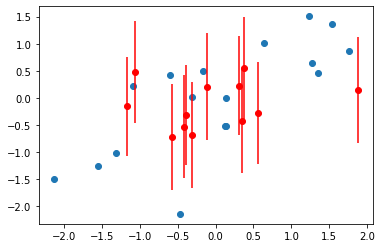

In [7]:
post = m15_7.get_samples()
B_impute = post['B_impute']
B_impute_mean = jnp.mean(B_impute,axis=0)
B_impute_std = jnp.std(B_impute,axis=0)

B_isnan = np.isnan(B)
B_nanidx = np.nonzero(B_isnan)[0]

plt.errorbar(x=M[B_nanidx], y=B_impute_mean, yerr=B_impute_std, fmt='ro')
plt.scatter(x=M, y=B)


In [8]:
# So observations show correlation between M and B
# However the imputed values do not show that correlation
# So need to be allow correlation between M and imputed

In [27]:
def model(M, B, K=None):

    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a, b_M, b_B = numpyro.sample('reg_coef', dist.Normal(0,0.5).expand([3]))
    
    # Bayesian imputation of missing B

    # Get index postions of observations where B is missing
    B_isnan = np.isnan(B)
    B_nanidx = np.nonzero(B_isnan)[0]
    num_nan = B_nanidx.shape[0]

    # Priors on mean, standard deviations and covariance of M and B
    M_mu = numpyro.sample('M_mu', dist.Normal(0,0.5))
    M_sigma = numpyro.sample('M_sigma', dist.Exponential(1))   
    B_mu = numpyro.sample('B_mu', dist.Normal(0,0.5))
    B_sigma = numpyro.sample('B_sigma', dist.Exponential(1))

    L_omega = numpyro.sample('L_omega', dist.LKJCholesky(2,0.5))
    L_Omega = jnp.matmul(jnp.diag(jnp.hstack([M_sigma, B_sigma])), L_omega)

    # Impute missing values of B
    B_impute = numpyro.sample("B_impute", dist.Normal(0, 1).expand([num_nan]).mask(False))
    
    # Interleave imputed and actual values of B
    B_imputed = jnp.asarray(B).at[B_nanidx].set(B_impute)

    # Condition on observed and imputed B values
    numpyro.sample("B", dist.MultivariateNormal(jnp.hstack([M_mu, B_mu]), scale_tril=L_Omega), obs=jnp.vstack([M, B_imputed]).T)

    # Use imputed B values in regression
    mu = a + b_M * M + b_B * B_imputed
    milk_energy = numpyro.sample('K', dist.Normal(mu, sigma), obs=K)


m15_8 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_8.run(random.PRNGKey(0), M=m_b_k[:,0], B=m_b_k[:,1], K=m_b_k[:,2])
m15_8.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 3445.00it/s, 15 steps of size 3.83e-01. acc. prob=0.91]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 B_impute[0]     -0.63      0.66     -0.64     -1.67      0.40   2537.18      1.00
 B_impute[1]     -0.67      0.71     -0.66     -1.83      0.49   2298.67      1.00
 B_impute[2]     -0.80      0.70     -0.80     -1.83      0.43   2798.09      1.00
 B_impute[3]     -0.42      0.65     -0.41     -1.47      0.64   2842.31      1.00
 B_impute[4]     -0.25      0.72     -0.23     -1.51      0.81   2106.98      1.00
 B_impute[5]     -0.74      0.70     -0.73     -1.97      0.30   2650.21      1.00
 B_impute[6]      0.06      0.66      0.05     -0.92      1.14   2844.26      1.00
 B_impute[7]      0.33      0.66      0.33     -0.77      1.39   2483.36      1.00
 B_impute[8]      0.55      0.70      0.54     -0.61      1.63   3190.91      1.00
 B_impute[9]     -0.15      0.66     -0.14     -1.23      0.93   2733.20      1.00
B_impute[10]      0.06      0.70      0.08     -1.12      1.17   2613.47      1.00
B_i

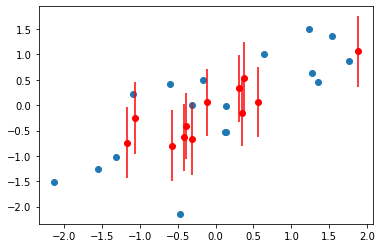

In [28]:
post = m15_8.get_samples()
B_impute = post['B_impute']
B_impute_mean = jnp.mean(B_impute,axis=0)
B_impute_std = jnp.std(B_impute,axis=0)

B_isnan = np.isnan(B)
B_nanidx = np.nonzero(B_isnan)[0]

plt.errorbar(x=M[B_nanidx], y=B_impute_mean, yerr=B_impute_std, fmt='ro')
plt.scatter(x=M, y=B)


In [34]:
# Get correlation between M and B
L = post['L_omega'].mean(axis=0)
print('correlation between M and B: ', (L @ L.T)[0,1])

correlation between M and B:  0.65219563


### Discrete cats

In [45]:
N_houses = 100
alpha = 5
beta = -3
k = 0.5
r = 0.2

rng = default_rng()
cat = rng.binomial(1, k, size=(N_houses))
notes = rng.poisson(np.exp(alpha + beta * cat))
R_C = rng.binomial(1, r, size=(N_houses))
cat_obs = np.where(R_C==0, cat, -9)



In [54]:

def model(c, rc, n):
    # Sneaking cat model
    k = numpyro.sample('k', dist.Beta(2, 2))
    numpyro.sample('cat | not missing', dist.BernoulliProbs(k), obs=c[rc==0] )

    # Singing birds model
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))

    # cat not missing
    mean = jnp.exp(a + b*c[rc==0])
    obs = numpyro.sample('obs', dist.Poisson(mean), obs=n[R_C==0])

    # cat missing
    custom_logprob = jnp.logaddexp(
        jnp.log(k) + dist.Poisson(jnp.exp(a + b)).log_prob(notes[rc == 1]), # array of the log probs of observing n notes, given cat is present, for all rows with missing c
        jnp.log(1 - k) + dist.Poisson(jnp.exp(a)).log_prob(notes[rc == 1]), # array of the log probs of observing n notes, given cat is not present, for all rows with missing c
    )
    numpyro.factor("notes|RC==1", custom_logprob) # this just includes the custom logprob into the Numpyro model



m15_9 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_9.run(random.PRNGKey(0), c=cat_obs, rc=R_C, n=notes)
m15_9.print_summary()


/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 3770.42it/s, 3 steps of size 7.11e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.99      0.01      4.99      4.97      5.01   2404.01      1.00
         b     -3.02      0.05     -3.02     -3.10     -2.93   1808.74      1.00
         k      0.55      0.05      0.55      0.47      0.63   1471.70      1.00

Number of divergences: 0


In [50]:
! pip install funsor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 KB 3.1 MB/s eta 0:00:00a 0:00:01


In [51]:
import funsor

In [53]:
# Following https://colab.research.google.com/github/pyro-ppl/numpyro/blob/master/notebooks/source/discrete_imputation.ipynb#scrollTo=QUlZSCPxbmRa

def model(c, rc, n):

    nobs = c.shape[0]

    # Prior k sneaking cat model
    k = numpyro.sample('k', dist.Beta(2, 2))

    # Priors for singing birds model
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))


    with numpyro.plate('obs', nobs):

        # Impute sneaking cats

        # mask out to not add log_prob to total likelihood right now
        cat_imp = numpyro.sample("cat_imp", dist.BernoulliProbs(k).mask(False), infer={"enumerate": "parallel"})

        # 'manually' calculate the log_prob
        log_prob = dist.BernoulliProbs(k).log_prob(cat_imp)

        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where((rc==0) & (cat_imp != c), -jnp.inf, log_prob)

        # add to total likelihood for sampler
        numpyro.factor("cat_obs", log_prob)

        # Singing birds model using imputed cats
        mean = jnp.exp(a + b*cat_imp)
        obs = numpyro.sample('notes', dist.Poisson(mean), obs=n)
        

m15_10 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_10.run(random.PRNGKey(0), c=cat_obs, rc=R_C, n=notes)
m15_10.print_summary()




/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:00<00:00, 3949.61it/s, 3 steps of size 7.99e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.99      0.01      4.99      4.97      5.01   2034.74      1.00
         b     -3.02      0.05     -3.02     -3.10     -2.94   1708.92      1.00
         k      0.55      0.05      0.55      0.46      0.63   1604.54      1.00

Number of divergences: 0
